# Author: Lukas Delaye
## Goal: Visualize the electric field impact of a probe at the Lyot plane to check for vignetting.
Here is a test with gaussian


# FIRST / COMPACT MODEL


In [27]:
# Imports and Path Configuration
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm

# Compact model
import corgihowfsc
from corgihowfsc.utils.howfsc_initialization import get_args, load_files
from howfsc.model.mode import CoronagraphMode

howfsc_root = os.path.dirname(os.path.abspath(corgihowfsc.__file__))
model_dir = os.path.join(howfsc_root, 'model')

# Flat DM for the reference e_field
dm1_flat_path = os.path.join(model_dir, 'dm1', 'dm_allzeros.fits')
dm2_flat_path = os.path.join(model_dir, 'dm2', 'dm_allzeros.fits')

# Arguments
args = get_args(
    niter=1,
    mode='nfov_band1',  # Adjust if working in band4
    precomp='precomp_jacs_always',
    jacpath=os.path.join(os.path.dirname(howfsc_root), 'temp'), # Temp path
    fileout=os.path.join(os.getcwd(), 'output_debug')
)
_, cfgfile, _, _, _, _, _, _ = load_files(args, howfsc_root)
cfg = CoronagraphMode(cfgfile)


In [29]:
# load DM
dm1_flat = fits.getdata(dm1_flat_path)
dm2_flat = fits.getdata(dm2_flat_path)

# Load probes (here the single actuator probe)
probe_filename = 'narrowfov_dmrel_1.0e-05_act0.fits'
probe_path = os.path.join(model_dir, 'probes', probe_filename)
probe_cmd = fits.getdata(probe_path)

# Apply probe to DM1
dm1_with_probe = dm1_flat + probe_cmd
dmlist_probe = [dm1_with_probe, dm2_flat]


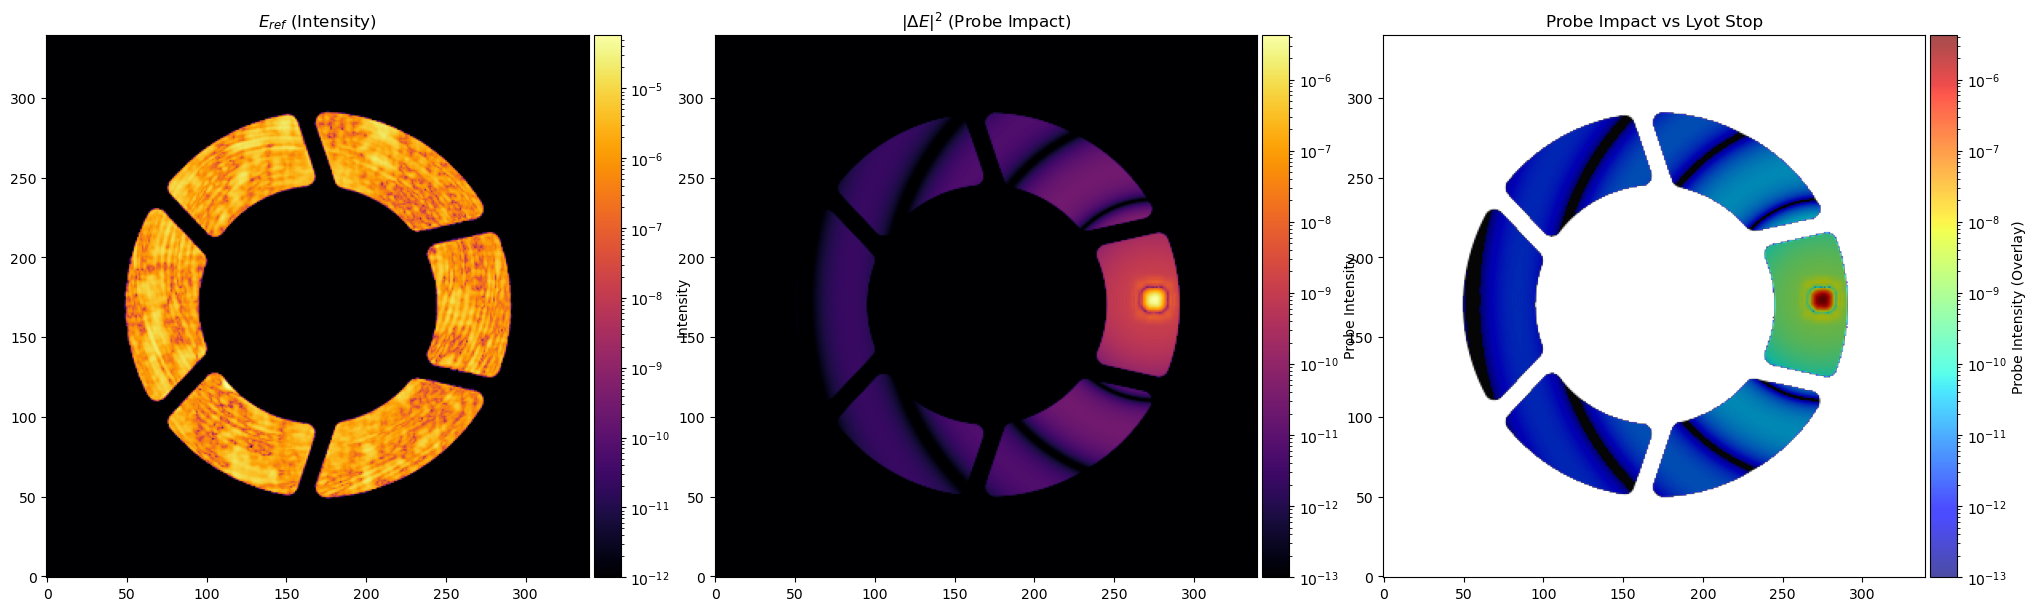

In [34]:
# Import
from matplotlib.colors import LogNorm

# Wavelenght 0
sl = cfg.sl_list[0]

lyot_mask_fits = np.abs(sl.lyot.e) # Amplitude transmission

# Propagation
dmlist_ref = [dm1_flat, dm2_flat] # Flat DMs from Cell 2
edm0_ref = sl.eprop(dmlist_ref)
E_lyot_ref = sl.proptolyot(edm0_ref)
I_ref = np.abs(E_lyot_ref)**2  # Intensity of starlight

# Probe e_field
edm0_probe = sl.eprop(dmlist_probe)
E_lyot_total = sl.proptolyot(edm0_probe)

# Delta_E to isolate probe impact
Delta_E = E_lyot_total - E_lyot_ref
I_probe = np.abs(Delta_E)**2

# Plotting
def add_colorbar(ax, im, label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    return cbar

fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

# E_field ref > I
data_ref = I_ref
vmin_ref = max(1e-12, data_ref.max() * 1e-10)
vmax_ref = data_ref.max()

# E_field probe > I
data_probe = I_probe
vmin_probe = max(1e-13, data_probe.max() * 1e-8)
vmax_probe = data_probe.max()

# 1
axes[0].set_title("$E_{ref}$ (Intensity)")
im1 = axes[0].imshow(data_ref, origin='lower', cmap='inferno',
                     norm=LogNorm(vmin=vmin_ref, vmax=vmax_ref))
add_colorbar(axes[0], im1, "Intensity")

# 2
axes[1].set_title(r"$|\Delta E|^2$ (Probe Impact)")
im2 = axes[1].imshow(data_probe, origin='lower', cmap='inferno',
                     norm=LogNorm(vmin=vmin_probe, vmax=vmax_probe))
add_colorbar(axes[1], im2, "Probe Intensity")

# 3
axes[2].set_title(r"Probe Impact vs Lyot Stop")

# Display
lyot_mask_resized = lyot_mask_fits

axes[2].imshow(lyot_mask_resized, origin='lower', cmap='gray_r', alpha=1.0) # gray_r so mask is dark

if vmax_probe > 0:
    # Mask low values for cleaner overlay
    probe_masked = np.ma.masked_where(data_probe < vmin_probe, data_probe)

    im3 = axes[2].imshow(probe_masked, origin='lower', cmap='jet',
                         norm=LogNorm(vmin=vmin_probe, vmax=vmax_probe), alpha=0.7)
    add_colorbar(axes[2], im3, "Probe Intensity (Overlay)")

# Save and Show
plt.savefig("test_lyot_compact_model.png")
plt.show()

# SECOND / FULL MODEL


In [14]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from scipy.ndimage import zoom
from matplotlib.patches import Patch
from matplotlib.colors import LogNorm
import yaml
import proper # Required for manual propagation
from corgihowfsc.utils.corgisim_manager import CorgisimManager
from howfsc.model.mode import CoronagraphMode
from howfsc.control.cs import ControlStrategy
from howfsc.util.loadyaml import loadyaml
from matplotlib.lines import Line2D
import roman_preflight_proper
if not os.path.exists('roman_preflight.py'):
    roman_preflight_proper.copy_here()

In [15]:
# Configs of paths
# CHANGE THE ROOT FOR YOUR LAPTOP it's mine here :)
repo_root = "C:/Users/ldelaye/Documents/Repos/corgihowfsc"
model_root = os.path.join(repo_root, "corgihowfsc", "model")
nfov_dir = os.path.join(model_root, "nfov_band1", "nfov_band1_360deg")
probes_dir = os.path.join(model_root, "probes")

# Config files
yaml_file = os.path.join(nfov_dir, "howfsc_optical_model.yaml")
hconf_file = os.path.join(model_root, "nfov_band1", "hconf_nfov_flat.yaml")
cstrat_file = os.path.join(nfov_dir, "cstrat_nfov_band1.yaml")

# Probe file to analyze
probe_filename = 'narrowfov_dmrel_1.0e-05_act0.fits'
probe_file = os.path.join(probes_dir, probe_filename)

## Load the entire optical prescription for the Roman telescope (pupil, mirrors, DMs, FPM) with the FULL MODEL
#### Notice : Using is_noise_free: True is perfect. For this diagnosis, we want to see the pure physics of diffraction, without photon or readout noise that would cloud the analysis.

In [16]:
# Inits
print("Initializing configuration objects...")
cfg = CoronagraphMode(yaml_file)
cstrat = ControlStrategy(cstrat_file)
hconf = loadyaml(hconf_file, custom_exception=TypeError)

# Initialize CorgisimManager (The Full Optical Model wrapper)
overrides = {
    'bandpass': '1',
    'is_noise_free': True,
    'output_dim': 153
}
manager = CorgisimManager(cfg, cstrat, hconf, cor='nfov_flat', corgi_overrides=overrides)

Initializing configuration objects...
Adding 0 off-axis sources


In [17]:
probe_map = fits.getdata(probe_file)

# My DM commands
# dm1_probe = Flat map + Probe perturbation
dm1_flat = np.zeros(probe_map.shape)
dm1_probe = dm1_flat + probe_map
dm2_flat = np.zeros(probe_map.shape)

## Instead of letting the simulator go all the way to the detector (which is what get_image does by default), we want to force the propagation engine (PROPER) to stop immediately after the Lyot Stop plane via the end_at_lyot_stop flag.
#### Notice : I calculate the total field with the probe, and subtract the reference field (without probe) to see only the effect off the probes.

In [18]:
#  My propagation to Lyot functions
def get_lyot_plane_field(mgr, dm1_v, dm2_v):
    """
    Propagates the wavefront through the optical system up to the Lyot Stop.
    Uses proper.prop_run_multi manually to bypass CorgiOptics restrictions.
    """
    # Create corgi object
    optics = mgr.create_optics(dm1_v, dm2_v, lind=0)

    # Retrieve the good keyword to stop at Lyot stop
    passvalue = optics.optics_keywords.copy()
    passvalue['end_at_fpm_exit_pupil'] = 1
    passvalue['use_lyot_stop'] = 1

    # Run PROPER
    (fields, sampling) = proper.prop_run_multi(
        'roman_preflight',
        optics.lam_um,
        1024, # Grid size (Pupil usually ~1000 pix)
        PASSVALUE=passvalue,
        QUIET=True
    )

    return fields[0]

E_ref = get_lyot_plane_field(manager, dm1_flat, dm2_flat)
E_probe = get_lyot_plane_field(manager, dm1_probe, dm2_flat)

# Differential field (The E-field added by the probe)
Delta_E = E_probe - E_ref

CorgiOptics initialized with proper keywords.
CorgiOptics initialized with proper keywords.


Loading Lyot Stop FITS from: C:\Users\ldelaye\Documents\Repos\corgihowfsc\corgihowfsc\model\nfov_band1\any\lyot_amp.fits


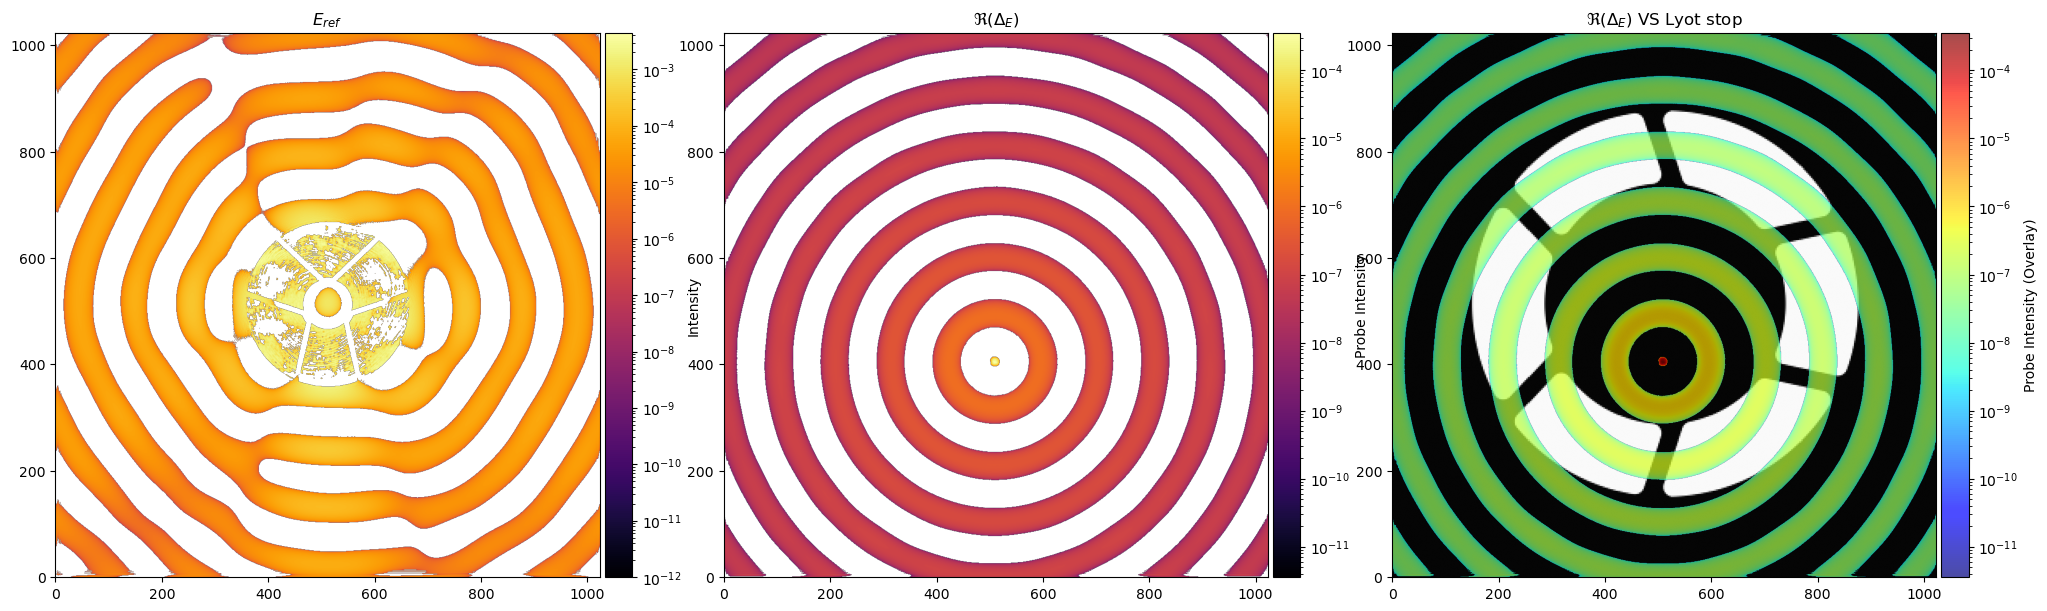

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Load Data
with open(yaml_file, 'r') as f:
    raw_cfg = yaml.safe_load(f)

lyot_rel_path = raw_cfg['sls'][0]['lyot']['afn']
lyot_path = os.path.normpath(os.path.join(nfov_dir, lyot_rel_path))
print(f"Loading Lyot Stop FITS from: {lyot_path}")
lyot_mask_fits = fits.getdata(lyot_path)

# Helper for colorbars
def add_colorbar(ax, im, label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    return cbar

fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

# Define vmin/vmax to prevent LogNorm(0) errors
data_ref = np.real(E_ref)
vmin_ref = max(1e-12, data_ref.max() * 1e-10)
vmax_ref = data_ref.max()

data_probe = np.real(Delta_E)
vmin_probe = max(1e-13, data_probe.max() * 1e-8)
vmax_probe = data_probe.max()

# --- Plot 1: Starlight ---
axes[0].set_title("$E_{ref}$")
im1 = axes[0].imshow(data_ref, origin='lower', cmap='inferno',
                     norm=LogNorm(vmin=vmin_ref, vmax=vmax_ref))
add_colorbar(axes[0], im1, "Intensity")

# --- Plot 2: Probe Energy ---
axes[1].set_title(r"$\Re(\Delta_E)$")
im2 = axes[1].imshow(data_probe, origin='lower', cmap='inferno',
                     norm=LogNorm(vmin=vmin_probe, vmax=vmax_probe))
add_colorbar(axes[1], im2, "Probe Intensity")

# --- Plot 3: Lyot Stop ---
axes[2].set_title(r"$\Re(\Delta_E)$ VS Lyot stop")


if lyot_mask_fits.shape != data_probe.shape:
    zoom_factor = data_probe.shape[0] / lyot_mask_fits.shape[0]
    lyot_mask_resized = zoom(lyot_mask_fits, zoom_factor, order=0)
else:
    lyot_mask_resized = lyot_mask_fits

axes[2].imshow(lyot_mask_resized, origin='lower', cmap='gray', alpha=1.0)

if vmax_probe > 0:
    probe_masked = np.ma.masked_where(data_probe < vmin_probe, data_probe)

    # Heatmap with transparency
    im3 = axes[2].imshow(probe_masked, origin='lower', cmap='jet',
                         norm=LogNorm(vmin=vmin_probe, vmax=vmax_probe), alpha=0.7)

    # Add Colorbar for the probe intensity
    add_colorbar(axes[2], im3, "Probe Intensity (Overlay)")
    plt.savefig("test_lyot")


## Interpretation of the final plot:

#### If the red contours (probe energy) fall on the gray/black areas (blocking areas of the mask), this means that the probe is vignetted.

#### If it is vignetted, the compact model (which assumes perfect or linear transmission) will be incorrect, and the wavefront estimate will be biased.